In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model

# reflect the tables
Base = automap_base()
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement

Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# See column names and what data looks like
session.query(Measurement).first().__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1c6f9166898>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1}

In [10]:
# Find the most recent date in the data set.
last_date = session.query(Measurement.date).order_by(Measurement.date).all()[-1]
last_date

('2017-08-23')

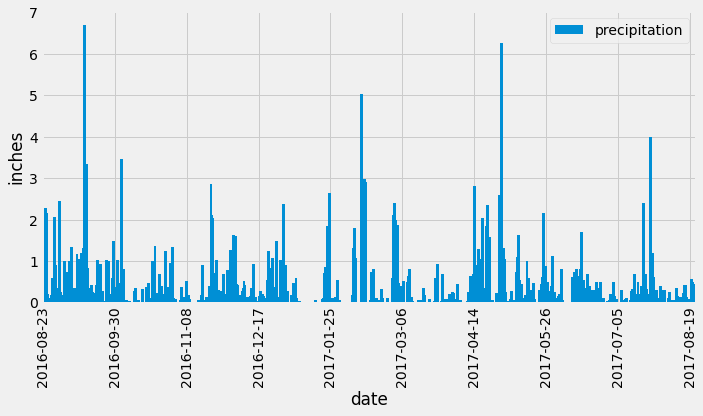

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
date = dt.datetime.strptime(last_date[0], '%Y-%m-%d')
year_ago = date - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, Measurement.prcp]
results = session.query(*sel).filter(Measurement.date >= year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['date', 'precipitation'])
df.set_index('date', inplace=True)

# Sort the dataframe by date
df.sort_index(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
df.plot.bar(figsize=(10,6), width=10)

plt.xticks(ticks=range(0, df.shape[0], 246), labels=list(df.index.values)[0::246])
plt.ylabel('inches')

plt.tight_layout()
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [42]:
# Design a query to calculate the total number stations in the dataset
session.query(Measurement).group_by(Measurement.station).count()

9

In [53]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
sel = [Measurement.station, func.count(Measurement.station)]

stations = session.query(*sel).group_by(Measurement.station).\
        order_by(func.count(Measurement.station).desc()).all()

pd.DataFrame(stations, columns=['Station', 'Count'])

,Station,Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [60]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [Measurement.station, 
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]

result = session.query(*sel).filter(Measurement.station == stations[0][0]).all()

pd.DataFrame(result, columns=['Station', 'Low Temp', 'High Temp', 'Avg Temp'])

,Station,Low Temp,High Temp,Avg Temp
0,USC00519281,54.0,85.0,71.663781


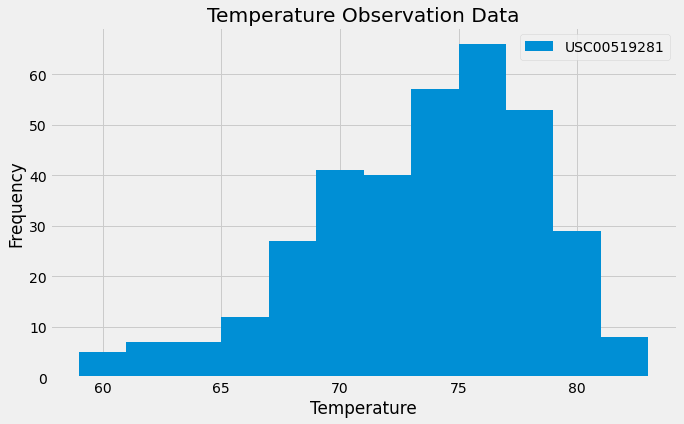

In [86]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temps = session.query(Measurement.tobs).\
        filter(Measurement.station == stations[0][0]).\
        filter(Measurement.date >= year_ago).all()

# Convert to list
temps_list = [t[0] for t in temps]

# Histogram
plt.figure(figsize=(10,6))
plt.hist(temps_list, bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Temperature Observation Data')
plt.legend([stations[0][0]])

plt.show()

# Close session

In [87]:
# Close Session
session.close()